# Multi-Label Text Classification
Kanisorn Puttaruska 6530049421

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2110446-dsde-2024-2/sample_submission.csv
/kaggle/input/2110446-dsde-2024-2/train.csv
/kaggle/input/2110446-dsde-2024-2/test.csv


In [2]:
from huggingface_hub import notebook_login
#notebook_login()

In [3]:
%%capture
!pip install wandb

In [4]:
import wandb
!wandb login "c9012dd7d55c154a87dc2d69a39ca5cfdc6cdc5f" 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
# Hyperparameters
MAX_LENGTH = 128
NUM_EPOCHS = 1
BATCH_SIZE = 32
THRESHOLD = 0.5
RANDOM_STATE = 49
oversampling_target = 5000

undersampling_theshold = 10000000 # no downsampling
a = 0.5
b = 0.05

"""
"clicknext/phayathaibert"
"airesearch/wangchanberta-base-att-spm-uncased"
"""

model_name = "clicknext/phayathaibert"

print(f"Model: {model_name}")

Model: clicknext/phayathaibert


## Import and Install Libraries

In [6]:
%%capture
!pip install datasets evaluate transformers

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import torch
from tqdm import tqdm

from IPython.display import display

from sklearn.utils import resample 
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from evaluate import load

# Load Dataset

In [8]:
dataset_path = '/kaggle/input/2110446-dsde-2024-2/'
df_train = pd.read_csv(dataset_path + "/train.csv")
df_test = pd.read_csv(dataset_path + "/test.csv")

In [9]:
df_train.head()

,id,comment,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,0,0,0,0,0,0,0,0,0,0,0,0
1,1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,0,0,0,0,0,0,0,0,0,0,0,0
2,2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,0,0,0,0,0,0,0,0,0,0,0,0
3,3,ปัญหาน้ำท่วมในซอยสวนพลู 1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df_test.head()

,id,comment
0,0,ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...
1,1,อันนี้ภาพทางเข้าถ่ายไว้นานแล้วค่ะ ในซอยถนนจะเป...
2,2,ขยะที่แยกสะพานควาย
3,3,ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒนะ ช่วงวิ...
4,4,- ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนน...


In [11]:
label_cols = df_train.columns[2:].values.tolist()
label_cols

['สำนักงานตำรวจแห่งชาติ',
 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย',
 'สภาเด็กและเยาวชนกรุงเทพมหานคร',
 'กรมควบคุมมลพิษ',
 'กรมสรรพสามิต',
 'การไฟฟ้านครหลวง',
 'กรมทางหลวง',
 'สำนักงานประกันสุขภาพแห่งชาติ',
 'การประปานครหลวง',
 'คณะกรรมการการพัฒนาเศรษฐกิจ',
 'กระทรวงการท่องเที่ยวและกีฬา',
 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200']

# Data Preparation

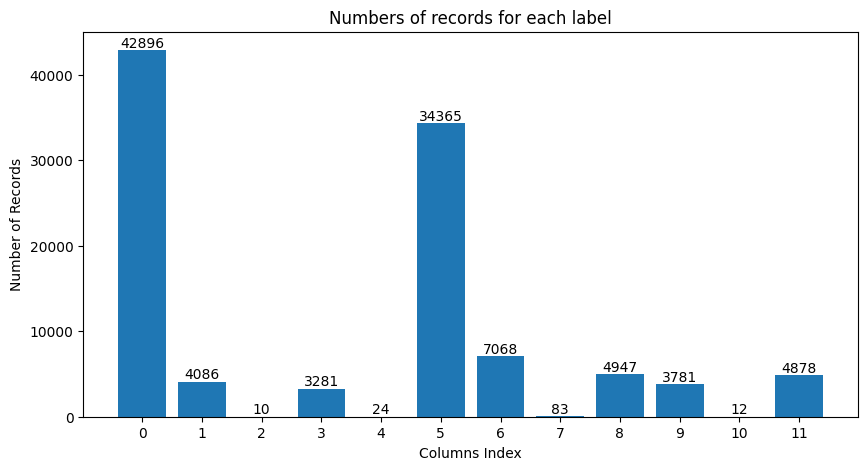

In [12]:
# count label
int_label = np.arange(0,12)
plt.figure(figsize=(10, 5))
bars = plt.bar(int_label, df_train.iloc[:, 2:].sum())

# Display the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.xticks(int_label)
plt.xlabel('Columns Index')
plt.ylabel('Number of Records')
plt.title('Numbers of records for each label')
plt.show()

## Oversampling Data 

In [13]:
# Identify columns with fewer than 100 records
label_counts = df_train.iloc[:, 2:].sum()
underrepresented_labels = label_counts[label_counts < oversampling_target].index

# Create a copy of the original dataset
df_oversampled = df_train.copy()

# Use tqdm to track progress
for label in tqdm(underrepresented_labels, desc="Oversampling Progress"):
    # Select rows where this label is present
    subset = df_train[df_train[label] == 1]
    
    sample_target = oversampling_target
    
    # sample based on the number of records
 #   if len(subset) < 50 :
 #       sample_target = int(len(subset) * 150)
 #   elif len(subset) < 100 :
 #       sample_target = int(len(subset) * 50)
 #   else :
 #       sample_target = oversampling_target
    
    # Oversample with replacement
    oversampled_subset = resample(subset, 
                                  replace=True, 
                                  n_samples=sample_target - len(subset),
                                  random_state=RANDOM_STATE)
    
    # Append to the original dataset
    df_oversampled = pd.concat([df_oversampled, oversampled_subset], ignore_index=True)

print(f"Oversampling completed. New dataset size: {df_oversampled.shape}")


Oversampling Progress: 100%|██████████| 9/9 [00:00<00:00, 68.64it/s]

Oversampling completed. New dataset size: (228520, 14)


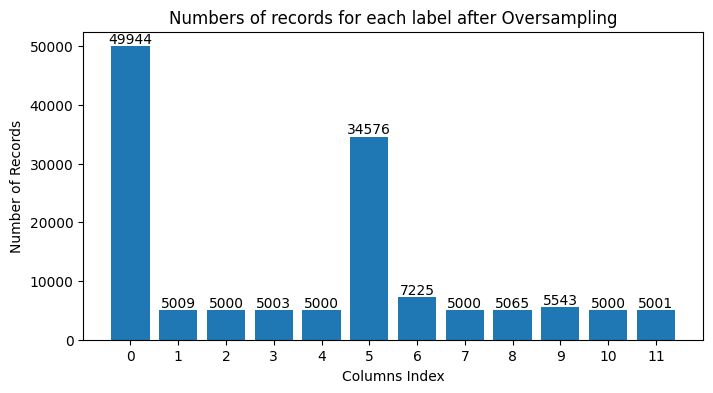

In [14]:
# count label

int_label = np.arange(0,12)
plt.figure(figsize=(8, 4))
bars = plt.bar(int_label, df_oversampled.iloc[:, 2:].sum())

# Display the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.xticks(int_label)
plt.xlabel('Columns Index')
plt.ylabel('Number of Records')
plt.title('Numbers of records for each label after Oversampling')
plt.show()

In [15]:
og_df_train = df_train
df_train = df_oversampled

In [16]:
data = []

# Loop through columns and collect index, label, and counts
for index, column in enumerate(df_train.columns[2:].values):
    data.append([column, df_train[column].sum()])

# Create a DataFrame
df_summary = pd.DataFrame(data, columns=["Label", "Counts"])

# Print DataFrame in a readable format
df_summary

,Label,Counts
0,สำนักงานตำรวจแห่งชาติ,49944
1,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,5009
2,สภาเด็กและเยาวชนกรุงเทพมหานคร,5000
3,กรมควบคุมมลพิษ,5003
4,กรมสรรพสามิต,5000
5,การไฟฟ้านครหลวง,34576
6,กรมทางหลวง,7225
7,สำนักงานประกันสุขภาพแห่งชาติ,5000
8,การประปานครหลวง,5065
9,คณะกรรมการการพัฒนาเศรษฐกิจ,5543


## Create new dataset with `comment` and `label` of list of ones and zeros of classes

In [17]:
df_train['label'] = df_train.iloc[:, 2:14].values.tolist()
df_train.drop(df_train.columns[2:14], axis=1, inplace=True)
df_train.head()


,id,comment,label
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,ปัญหาน้ำท่วมในซอยสวนพลู 1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [18]:
# Convert the lists in the 'label' column to tuples
df_train['label_tuple'] = df_train['label'].apply(tuple)

# Group by the new 'label_tuple' column
class_count = df_train.groupby(['label_tuple'])['comment'].count().sort_values(ascending=False).reset_index()
display(class_count)
df_train.drop(columns=['label_tuple'], inplace=True)

,label_tuple,comment
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",102333
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",42212
2,"(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)",32543
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)",5803
4,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)",4807
...,...,...
68,"(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1)",1
69,"(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1)",1
70,"(1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0)",1
71,"(1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0)",1


## Undersampling Overrepresented Data

In [19]:

# Convert lists to tuples in the label column
df_oversampled['label_tuple'] = df_oversampled['label'].apply(tuple)

# Count occurrences of each label
class_count = df_oversampled.groupby('label_tuple')['comment'].count().reset_index()

# Identify labels with counts above threshold
labels_to_downsample = class_count[class_count['comment'] > undersampling_theshold]['label_tuple']

# Function to downsample
def downsample_group(group):
    count = len(group)
    if count > undersampling_theshold:
        keep_ratio = min(1.0, a * (count ** b))
        return group.sample(frac=keep_ratio, random_state=RANDOM_STATE) 
    return group 

# Apply downsampling
df_downsampled = df_oversampled.groupby('label_tuple', group_keys=False).apply(downsample_group)

# Drop temporary column
df_downsampled.drop(columns=['label_tuple'], inplace=True)

# Display new class count
new_class_count = df_downsampled.groupby(df_downsampled['label'].apply(tuple))['comment'].count().sort_values(ascending=False).reset_index()
display(new_class_count)


<ipython-input-19-45db1a998301>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_downsampled = df_oversampled.groupby('label_tuple', group_keys=False).apply(downsample_group)


,label,comment
0,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",102333
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",42212
2,"(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)",32543
3,"(0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0)",5803
4,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0)",4807
...,...,...
68,"(1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1)",1
69,"(1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1)",1
70,"(1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0)",1
71,"(1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0)",1


In [20]:
df_downsampled.head()

,id,comment,label
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,ปัญหาน้ำท่วมในซอยสวนพลู 1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [21]:
df_train = df_downsampled.copy()

In [22]:
sample_df = df_train.sample(frac=1)

for record in sample_df.iloc[:5].values:
    print("record id",record[0])
    print(record[1])
    print(record[2])
    print("-" * 100)

record id 18618
สะเก็ดไฟจากการก่อสร้างรถไฟฟ้าตกลงมาข้างล่างที่ถนน ตรงสี่แยกลาดพร้าวรัชดาครับ
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------------------------
record id 105535
ปัญหา: ขอร้องเรียนพฤติกรรมเจ้าหน้าที่เก็บขยะ เมื่อวันที่ 1 ตุลาคม 2566 เวลา 12.00 น. รถขยะได้เข้ามาเก็บขยะ แต่ได้ทำพฤติกรรมไม่เหมาะสม มีการคัดแยกขยะ บีบน้ำขยะ และมีการล้างตัว ทำให้ส่งกลิ่นเหม็นรบกวน
ซอย: ลาดพร้าววังหิน 64
ถนน: ลาดพร้าว
จุดสังเกต: บริเวณท้ายซอยดังกล่าว
เขต: ลาดพร้าว
#1555
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
----------------------------------------------------------------------------------------------------
record id 177882
(แจ้งครั้งที่ 5(1)/2567) ผมต้องสัญจรผ่านตลาดบางแคทุกวันแล้วก็เห็นเป็นประจำแบบนี้ทุกวันเคยแจ้งเรื่องไปหลายครั้งแล้วก็ไม่ได้พัฒนาขึ้นเลยอยากให้มีตำรวจที่ปฏิบัติหน้าที่จริงๆจังจัง การจราจรติดขัดมาก รถมอเตอร์ไซต์, สามล้อและรถแท็กซี่จอดกีดขวางการจราจรทำให้ รถสัญจรไปมาไม่สะดวกตลอดเวลา
[1, 0, 0, 0, 0, 0, 0, 0, 0, 

## Clean comment data

ref: https://www.analyticsvidhya.com/blog/2022/01/text-cleaning-methods-in-nlp/

In [23]:
unimportant_words = ['ครับ', 'ค่ะ', 'คะ', 'สวัสดี', 'ผม', 'ๆ' ,'สิ', 'นะ']

def remove_unimportant_words(text):
    for word in unimportant_words:
        text = text.replace(word, '')
    return text

In [24]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           "\U0001F600-\U0001F64F"  # emoticons
                           "\U0001F300-\U0001F5FF"  # symbols & pictographs
                           "\U0001F680-\U0001F6FF"  # transport & map symbols
                           "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "\U00002702-\U000027B0"
                           "\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [25]:
# Remove leading/trailing whitespaces and internal multiple spaces
def clean_text(text):
    text = text.str.lower()
    text = text.str.strip() # remove leading/trailing whitespaces
    text = text.str.replace(r'http\S+', 'u', regex=True) # replace URLs with 'u'
    text = text.str.replace("\n", " ", regex=False)
    text = text.str.replace(r'\b\d+\.\s*', '', regex=True) # remove index numbers
    text = text.str.replace(r'[^\w\s\u0E01-\u0E5B]', '', regex=True)
    text = text.str.replace(r'\s+\d+\s+', ' n ', regex=True) # replace all numbers with 'n'
    text = text.str.replace(r'\s+', ' ', regex=True) # remove multiple spaces
    text = text.apply(remove_emoji) # remove emojis
    text = text.apply(remove_unimportant_words) # remove unimportant words
    return text

In [26]:
text = """
ี📣💡🛣️ แจ้งไฟถนนดับ
*️⃣หมายเลขเสาไฟ  L 5/30
👉 ส่งต่อ กรมทางหลวง
📌ตอม่อ 181
🛣️ ถ.ประเสริฐมนูกิจ
🙏👩‍🔧 ขอขอบคุณ เจ้าหน้าที่ทุกท่าน
ในการจัดการปัญหานี้
"""
print(clean_text(pd.Series(text).astype(str))[0][:300])

ี แจ้งไฟถนนดับ หมายเลขเสาไฟ l n ส่งต่อ กรมทางหลวง ตอม่อ n ถประเสริฐมนูกิจ ขอขอบคุณ เจ้าหน้าที่ทุกท่าน ในการจัดการปัญหานี้


In [27]:
sample_df = df_train.sample(frac=1)[:5]

sample_df['clean_comment'] = clean_text(sample_df['comment'])
display(sample_df[['comment', 'clean_comment']])


,comment,clean_comment
190761,รบกวนเจ้าหน้าที่เทศกิจตัดนั้นค้าขายแผงลอย มาลั...,รบกวนเจ้าหน้าที่เทศกิจตัดนั้นค้าขายแผงลอย มาลั...
118781,ช่างซ่อมฟุตบาต ทางเท้า ในเวลา 23:00 ถึง ตี 4 ...,ช่างซ่อมฟุตบาต ทางเท้า ในเวลา n ถึง ตี n ใกล้แ...
215395,ขออนุญาตใช้รูปเดิม เพราะปัญหายังไม่ได้แก้ไขแต่...,ขออนุญาตใช้รูปเดิม เพราะปัญหายังไม่ได้แก้ไขแต่...
220265,ศูนย์เรื่องราวร้องทุกข์ ได้รับการประสานผ่านระบ...,ศูนย์เรื่องราวร้องทุกข์ ได้รับการประสานผ่านระบ...
186945,ไฟฟ้าส่องสว่างกระพริบๆทำให้เสียสายตาทำให้การสั...,ไฟฟ้าส่องสว่างกระพริบทำให้เสียสายตาทำให้การสัญ...


In [28]:
df_train['comment'] = clean_text(df_train['comment'])

Split data

In [29]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df_train['comment'].tolist(), df_train['label'], test_size=0.2, random_state=RANDOM_STATE)

In [30]:
# use for evaluation
og_df_train['label'] = og_df_train.iloc[:, 2:14].values.tolist()
og_df_train.drop(og_df_train.columns[2:14], axis=1, inplace=True)

og_df_train['comment'] = clean_text(og_df_train['comment'])
og_train_texts, og_val_texts, og_train_labels, og_val_labels = train_test_split(og_df_train['comment'].tolist(), og_df_train['label'], test_size=0.2, random_state=RANDOM_STATE)

In [31]:
train_texts[:5]

['ถนนไม่มีเส้นแบ่งช่องจราจร มาเป็นเวลานานมาก',
 'ปัญหา ไฟส่องสว่างทาง ดับชำรุด ทั้งหมด ประมาณ n ต้น ขอให้เจ้าหน้าที่เข้ามาจัดการ พิกัดจุดสังเกต หัวมุมซอยอารีสัมพันธ์สี่ เลยกรมประชาสัมพันธ์ บ้านเลขที่ ถนน พระราม n ซอย อารีสัมพันธ์ เขต พญาไท แขวง พญาไท 1555',
 'แจ้งเรื่องเปิดเพลงเสียงดังในชุมชนเปิดมาตั้งแต่9โมงเช้าแล้วยังไม่หยุดเลย10กว่าชมแล้วตอนนี้หูอื้อหมดแล้วแจ้งไปแล้ว1ครั้งไม่ทราบว่ามีเจ้าหน้าที่เข้ามาหรือยังยังเปิดดังเหมือนเดิมยิ่งดึกยิ่งดังมีหลายที่ใกล้กันเสียงอัดแน่นรวมกันไปหมดเลยเปิดในที่โล่งแจ้งช่วยมาตรวจสอบด้วยพรุ่งนี้ต้องทำงานไม่ได้พักผ่อนเลยในซอยปรีดีพนมยงค์46แยก4หลายที่เลย',
 'อุบัติเหตุ บน สะพานสูงสวนผักสามสอง',
 'สะพานลอยที่เชื่อไปสถานีไฟฉายที่บอกว่าจะแล้วเสร็จใน ตุลา66 ตอนนี้ยังไม่เริ่ม ไม่ทราบว่าจะเริ่มเมื่อไหร่เสร็จเมื่อไหร่']

# Model Set up

In [32]:
#@title Choose Pretrained Model
#create tokenizer
tokenizer = AutoTokenizer.from_pretrained(
                model_name,
                revision='main',
                max_length=MAX_LENGTH,
                truncation=True,
                return_tensors="pt"
                )

#create model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    revision='main',
    num_labels=12,
    problem_type="multi_label_classification"
)

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
vocab = tokenizer.get_vocab()
print('u' in vocab)

True


In [34]:
def tokenize_function(examples):
    return tokenizer(examples["comment"], return_token_type_ids=True, truncation=True, max_length=MAX_LENGTH)

train_labels_tensor = torch.tensor(np.array(train_labels.tolist(), dtype=np.float32))
val_labels_tensor = torch.tensor(np.array(val_labels.tolist(), dtype=np.float32))

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"comment": train_texts, "labels": train_labels_tensor})
val_dataset = Dataset.from_dict({"comment": val_texts, "labels": val_labels_tensor})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})

Map:   0%|          | 0/182816 [00:00<?, ? examples/s]

Map:   0%|          | 0/45704 [00:00<?, ? examples/s]

In [35]:
og_val_labels_tensor = torch.tensor(np.array(og_val_labels.tolist(), dtype=np.float32))
og_val_dataset = Dataset.from_dict({"comment": og_val_texts, "labels": og_val_labels_tensor})
og_val_dataset = og_val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40925 [00:00<?, ? examples/s]

# Training

In [36]:
metric = load("accuracy")

eval_metrics = "Partial"
## Check partial labels

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > THRESHOLD).int()
    # Calculate accuracy for each label
    label_accuracies = (predictions == torch.tensor(labels)).float().mean(axis=0)
    # average accuracy across all labels
    accuracy = label_accuracies.mean()
    return {"accuracy": accuracy}

In [37]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    #report_to="none"  # Disable all tracking integrations (e.g., wandb
)

In [38]:
wandb.init(project="DSDE-midterm", config=training_args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kanisornputta. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250312_011210-tkd07ruj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sage-eon-123
wandb: ⭐️ View project at https://wandb.ai/kanisornputta/DSDE-midterm
wandb: 🚀 View run at https://wandb.ai/kanisornputta/DSDE-midterm/runs/tkd07ruj


In [39]:
print('Evaluate metrics:', eval_metrics) 

Evaluate metrics: Partial


In [40]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print('Evaluate metrics:', eval_metrics) 
print()
# Move model to the device (GPU if available)
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()




Using device: cuda
Evaluate metrics: Partial



<ipython-input-40-1f8d2c21a44d>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.060600,0.058916,0.980348


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=2857, training_loss=0.07857912372032329, metrics={'train_runtime': 3012.0484, 'train_samples_per_second': 60.695, 'train_steps_per_second': 0.949, 'total_flos': 1.196499699062784e+16, 'train_loss': 0.07857912372032329, 'epoch': 1.0})

In [41]:
eval_results = trainer.evaluate()
print(eval_results)
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.058916158974170685, 'eval_accuracy': 0.9803481101989746, 'eval_runtime': 228.3018, 'eval_samples_per_second': 200.191, 'eval_steps_per_second': 3.132, 'epoch': 1.0}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁▁
wandb:               eval/loss ▁▁
wandb:            eval/runtime █▁
wandb: eval/samples_per_second ▁█
wandb:   eval/steps_per_second ▁█
wandb:             train/epoch ▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
wandb:       train/global_step ▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
wandb:         train/grad_norm ▅▂▃▃▁▄▁▃▃▃▄▃▃▄▃▅▆▄▄▄▃▃▅▂▃▃▃▃▄▃▃█▄▆▄▄▅▃▄▃
wandb:     train/learning_rate ███▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
wandb:              train/loss ██▇▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:            eval/accuracy 0.98035
wandb:                eval/loss 0.05892
wandb:             eval/runtime 228.3018
wandb:  eval/samples_per_second 200.191
wandb:    eval/steps_per_second 3.132
wandb:               total_flos 1.196499699062784e+16
wandb:              train/epoch 1
wandb:        train/global_step 2857
wan

# Save and Load Weights

In [42]:
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/sentencepiece.bpe.model',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [43]:
import shutil

shutil.make_archive("saved_model", 'zip', "./saved_model")

'/kaggle/working/saved_model.zip'

In [44]:
# Load the model later
model = AutoModelForSequenceClassification.from_pretrained("./saved_model")
tokenizer = AutoTokenizer.from_pretrained("./saved_model")

# Inference

In [45]:
df_test['comment'] = clean_text(df_test['comment'])
df_test.head()

,id,comment
0,0,ไม่มีทางเท้าคนเดินจากสะพานกรุงธนบุรีไปวัดราชผา...
1,1,อันนี้ภาพทางเข้าถ่ายไว้นานแล้ว ในซอยถนนจะเป็นห...
2,2,ขยะที่แยกสะพานควาย
3,3,ช่วงเร่งคืนพื้นที่ช่องจราจรถนนแจ้งวัฒ ช่วงวิภา...
4,4,ไฟถนนไม่ติด เป็นทางยาว คนเดินถนนลำบากมาก ถนนร...


In [46]:
THRESHOLD = 0.31

In [47]:
def predict(texts):
    inputs = tokenizer(texts, max_length=MAX_LENGTH, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()
    output = (probs[0] > THRESHOLD).astype(int)
    return output.tolist()


texts = ["ข้อความภาษาไทยทดสอบ"]
predictions = predict(texts)
print(predictions)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [48]:
# Define the function to map predictions
def map_prediction(example):
    pred = example['prediction']  # Already a list of predictions
    for idx, label in enumerate(label_cols):
        example[label] = pred[idx]
    return example

In [49]:
sample_df_test = df_test.sample(frac=1)[:5]

sample_df_test['prediction'] = sample_df_test['comment'].apply(predict)
sample_df_test = sample_df_test.apply(map_prediction, axis=1)
sample_df_test.drop(columns=['prediction'], inplace=True)
display(sample_df_test)

,id,comment,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
5152,5152,ไฟสาธารณะไม่ติด แจ่งเรื่องไปตั้งแต่ n งหา ยังไ...,0,0,0,0,0,1,0,0,0,0,0,0
9741,9741,พื้นผิวฟุตบาทยุบตัว,0,0,0,0,0,0,0,0,0,0,0,0
10010,10010,มีต้นไม้นาดใหญ่ล้มต้นซอยรามคำแหง n ต้องใช้รถเฮียบ,0,0,0,0,0,0,0,0,0,0,0,0
5279,5279,มีบุคคลนำซากรถมาจอดทิ้งไว้,1,0,0,0,0,0,0,0,0,0,0,0
5684,5684,รบกวนหน่วยงานที่ดูแลพื้นที่ ถนนลาซาล ฝั่งศรีนค...,1,0,0,0,0,0,0,0,0,0,0,0


In [50]:
from tqdm import tqdm

tqdm.pandas()  # Enable progress_apply
df_test['prediction'] = df_test['comment'].apply(predict)

#df_test['prediction'] = df_test['comment'].apply(predict)
#df_test['prediction'] = df_test['comment'].progress_apply(predict)

In [51]:
# Apply map_prediction function to each row of df_test
tqdm.pandas()
df_test = df_test.apply(map_prediction, axis=1)

In [52]:
output_df = df_test.drop(columns=['prediction'])
output_df.drop(columns=['comment'], inplace=True)


In [53]:
output_df.head()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,1,0,0,0,0,0
4,4,0,0,0,0,0,1,0,0,0,0,0,0


# Save Submission

In [54]:
output_df.shape

(10810, 13)

In [55]:
csv_path = f'os{oversampling_target}-us{undersampling_theshold}-{a}-{b}-ml{MAX_LENGTH}-b{BATCH_SIZE}-{NUM_EPOCHS}e-th{THRESHOLD}.csv'
print(csv_path)

# used when submitting notebook
csv_path = 'submission.csv'


output_df.to_csv(csv_path, index=False)

os5000-us10000000-0.5-0.05-ml128-b32-1e-th0.31.csv


# Evaluation

In [56]:
THRESHOLD = 0.3

## Oversampled evaluation

In [57]:
wandb.init(project="DSDE-midterm", config=training_args)

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250312_022156-zyllqn7m
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run atomic-star-124
wandb: ⭐️ View project at https://wandb.ai/kanisornputta/DSDE-midterm
wandb: 🚀 View run at https://wandb.ai/kanisornputta/DSDE-midterm/runs/zyllqn7m


In [58]:
val_labels_df = pd.DataFrame(val_labels.tolist(), columns=label_cols)
val_labels_df.head()

,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0


In [59]:
predictions = trainer.predict(dataset["validation"])
predictions = (torch.sigmoid(torch.tensor(predictions.predictions)) > THRESHOLD).int()
predictions_pd = pd.DataFrame(predictions.tolist(), columns=label_cols)
predictions_pd.head()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0


In [60]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           test/accuracy ▁
wandb:               test/loss ▁
wandb:            test/runtime ▁
wandb: test/samples_per_second ▁
wandb:   test/steps_per_second ▁
wandb: 
wandb: Run summary:
wandb:           test/accuracy 0.9784
wandb:               test/loss 0.05892
wandb:            test/runtime 226.4773
wandb: test/samples_per_second 201.804
wandb:   test/steps_per_second 3.157
wandb: 
wandb: 🚀 View run atomic-star-124 at: https://wandb.ai/kanisornputta/DSDE-midterm/runs/zyllqn7m
wandb: ⭐️ View project at: https://wandb.ai/kanisornputta/DSDE-midterm
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250312_022156-zyllqn7m/logs


In [61]:
from sklearn.metrics import f1_score

f1_macro = f1_score(val_labels_df, predictions_pd, average='macro')
print(f"F1 Macro: {f1_macro}") 

F1 Macro: 0.7209642228265087


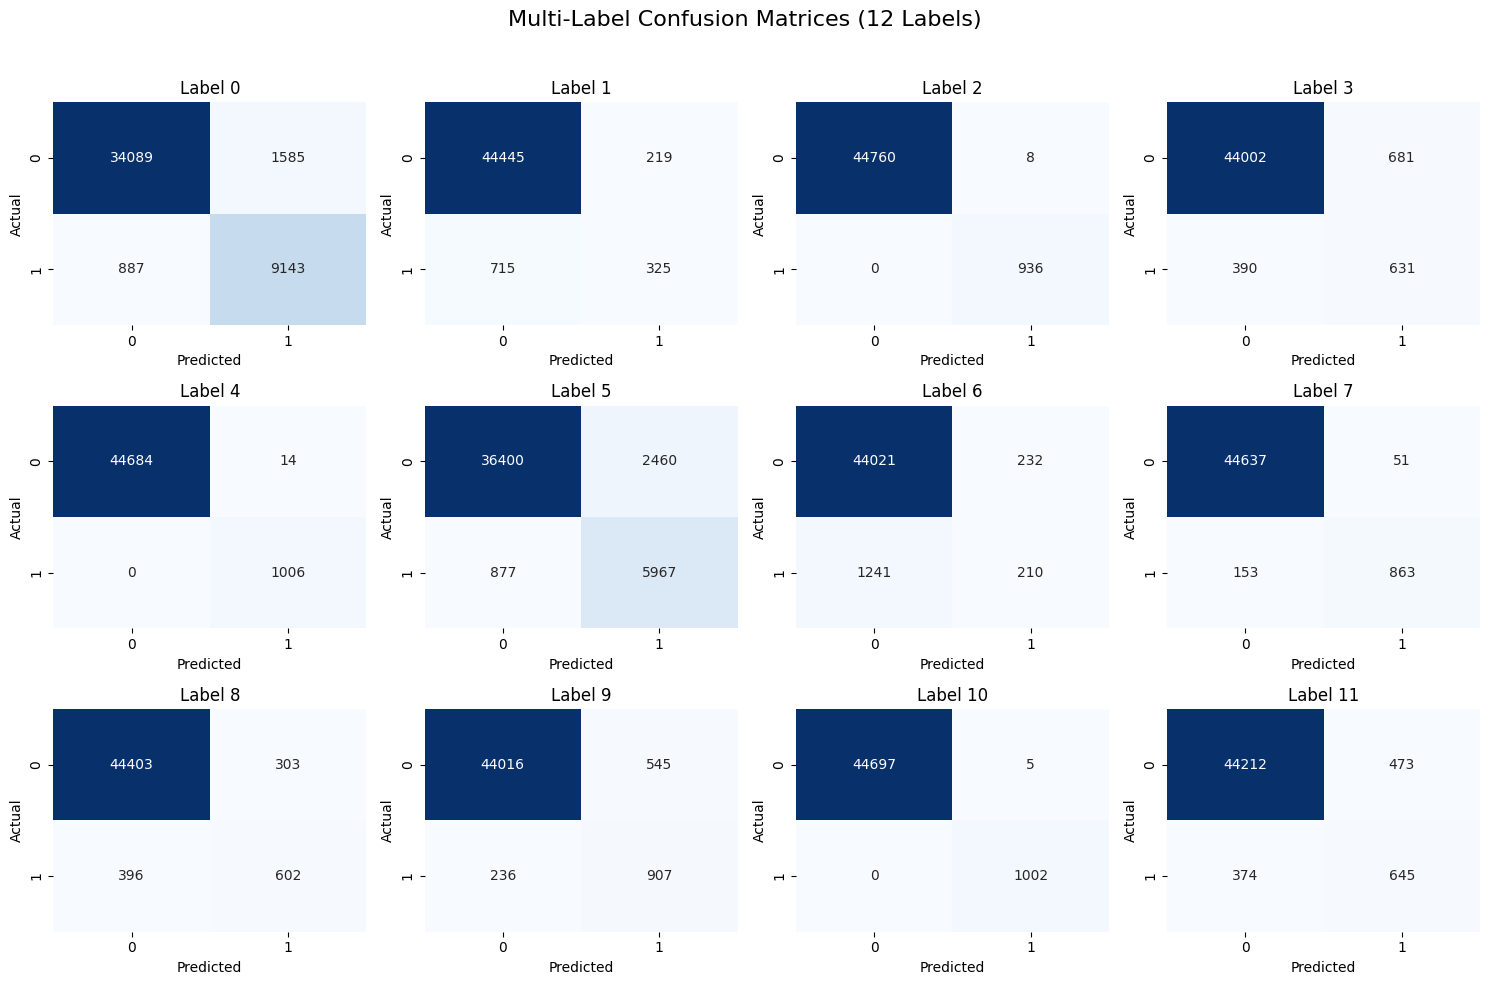

In [62]:
# Confusion Matrix
from sklearn.metrics import multilabel_confusion_matrix, f1_score

import seaborn as sns

cm_list = multilabel_confusion_matrix(val_labels_df, predictions_pd)

# Create a figure for plotting
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 matrices
fig.suptitle("Multi-Label Confusion Matrices (12 Labels)", fontsize=16)

# Iterate over each label's confusion matrix
for i, ax in enumerate(axes.flat):
    cm = cm_list[i]  # Get the confusion matrix for label i
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Label {i}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()



In [63]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(val_labels_df, predictions_pd, target_names=[f"Label {i}" for i in range(12)])

# Print the report
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Label 0       0.85      0.91      0.88     10030
     Label 1       0.60      0.31      0.41      1040
     Label 2       0.99      1.00      1.00       936
     Label 3       0.48      0.62      0.54      1021
     Label 4       0.99      1.00      0.99      1006
     Label 5       0.71      0.87      0.78      6844
     Label 6       0.48      0.14      0.22      1451
     Label 7       0.94      0.85      0.89      1016
     Label 8       0.67      0.60      0.63       998
     Label 9       0.62      0.79      0.70      1143
    Label 10       1.00      1.00      1.00      1002
    Label 11       0.58      0.63      0.60      1019

   micro avg       0.77      0.81      0.79     27506
   macro avg       0.74      0.73      0.72     27506
weighted avg       0.76      0.81      0.78     27506
 samples avg       0.45      0.45      0.44     27506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Original Evaluation

In [64]:
val_labels_df = pd.DataFrame(og_val_labels.tolist(), columns=label_cols)
val_labels_df.head()

,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0


In [65]:
wandb.init(project="DSDE-midterm", config=training_args)

wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250312_022550-sh42q693
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run curious-resonance-125
wandb: ⭐️ View project at https://wandb.ai/kanisornputta/DSDE-midterm
wandb: 🚀 View run at https://wandb.ai/kanisornputta/DSDE-midterm/runs/sh42q693


In [66]:
predictions = trainer.predict(og_val_dataset)
predictions = (torch.sigmoid(torch.tensor(predictions.predictions)) > THRESHOLD).int()
predictions_pd = pd.DataFrame(predictions.tolist(), columns=label_cols)
predictions_pd.head()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           test/accuracy ▁
wandb:               test/loss ▁
wandb:            test/runtime ▁
wandb: test/samples_per_second ▁
wandb:   test/steps_per_second ▁
wandb: 
wandb: Run summary:
wandb:           test/accuracy 0.97764
wandb:               test/loss 0.05821
wandb:            test/runtime 203.261
wandb: test/samples_per_second 201.342
wandb:   test/steps_per_second 3.149
wandb: 
wandb: 🚀 View run curious-resonance-125 at: https://wandb.ai/kanisornputta/DSDE-midterm/runs/sh42q693
wandb: ⭐️ View project at: https://wandb.ai/kanisornputta/DSDE-midterm
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250312_022550-sh42q693/logs


In [68]:
from sklearn.metrics import f1_score

f1_macro = f1_score(val_labels_df, predictions_pd, average='macro')
print(f"F1 Macro: {f1_macro}") 

F1 Macro: 0.5140777955468284


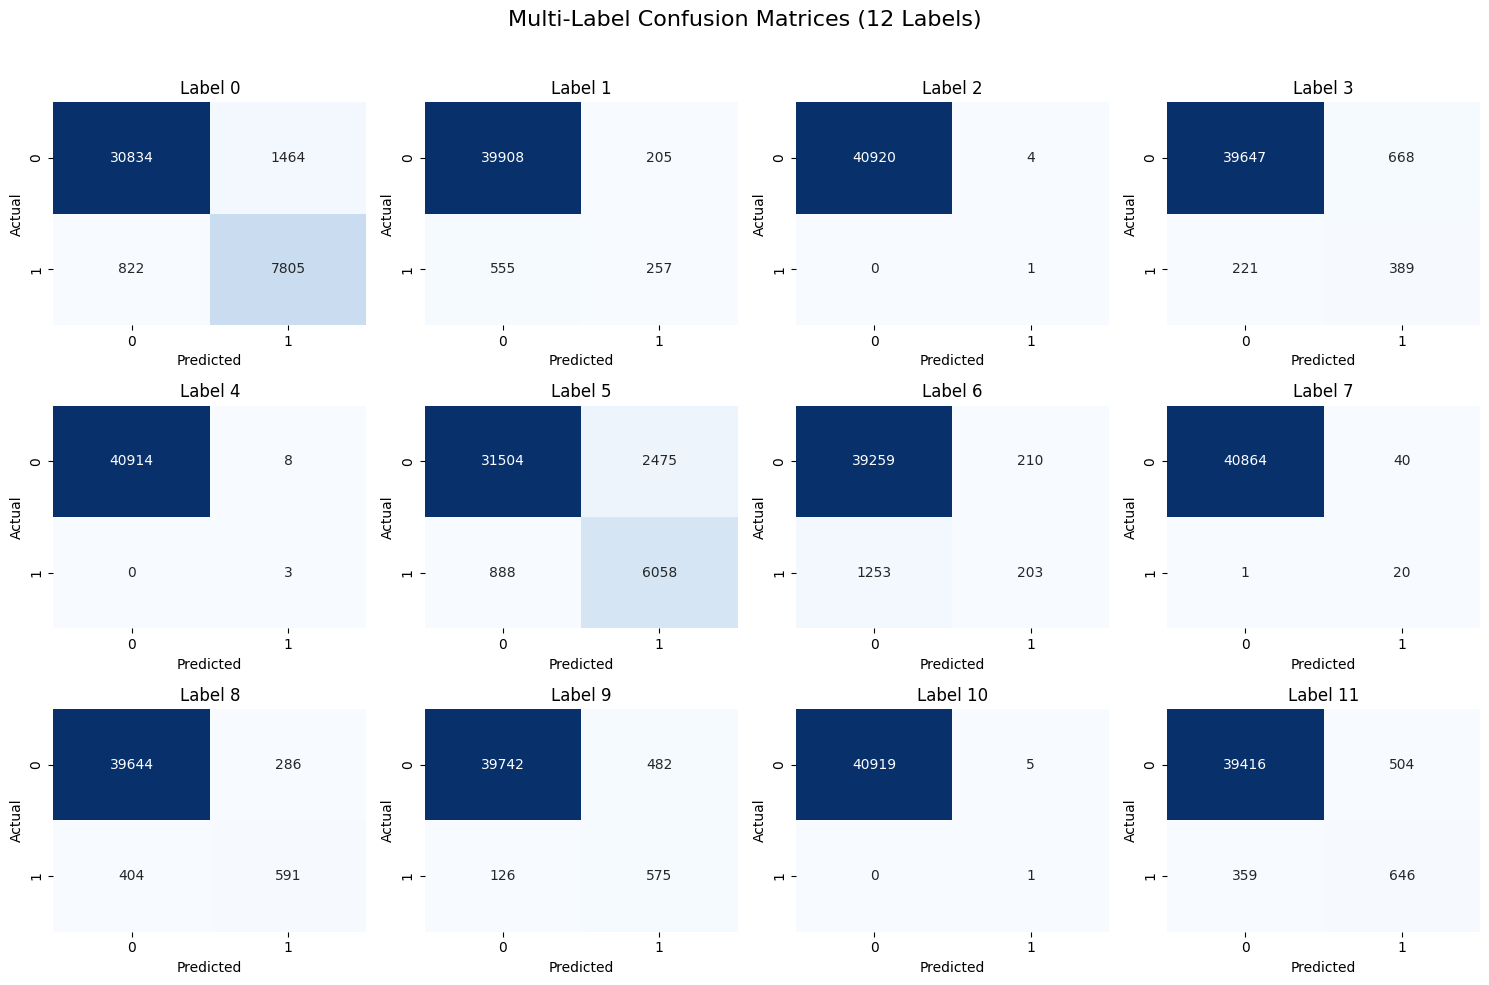

In [69]:
# Confusion Matrix
from sklearn.metrics import multilabel_confusion_matrix, f1_score

import seaborn as sns

cm_list = multilabel_confusion_matrix(val_labels_df, predictions_pd)

# Create a figure for plotting
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 3 rows, 4 columns for 12 matrices
fig.suptitle("Multi-Label Confusion Matrices (12 Labels)", fontsize=16)

# Iterate over each label's confusion matrix
for i, ax in enumerate(axes.flat):
    cm = cm_list[i]  # Get the confusion matrix for label i
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Label {i}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()



In [70]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(val_labels_df, predictions_pd, target_names=[f"Label {i}" for i in range(12)])

# Print the report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Label 0       0.84      0.90      0.87      8627
     Label 1       0.56      0.32      0.40       812
     Label 2       0.20      1.00      0.33         1
     Label 3       0.37      0.64      0.47       610
     Label 4       0.27      1.00      0.43         3
     Label 5       0.71      0.87      0.78      6946
     Label 6       0.49      0.14      0.22      1456
     Label 7       0.33      0.95      0.49        21
     Label 8       0.67      0.59      0.63       995
     Label 9       0.54      0.82      0.65       701
    Label 10       0.17      1.00      0.29         1
    Label 11       0.56      0.64      0.60      1005

   micro avg       0.72      0.78      0.75     21178
   macro avg       0.48      0.74      0.51     21178
weighted avg       0.72      0.78      0.74     21178
 samples avg       0.39      0.40      0.39     21178



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
